## This file is used to compile and test the Fortran code

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import ast

In [2]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

echo "===== cleaning up ====="
make clean
echo "===== compiling ====="
make VERSION=mpi

===== cleaning up =====
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
===== compiling =====
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-mpi.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o m_partitioner.o stencil2d-mpi.o -o stencil2d-mpi.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-mpi.x' (lite-samples) ...OK


cp stencil2d-mpi.x stencil2d.x


In [3]:
output = !gprof srun -n 3 ./stencil2d-mpi.x+orig --nx 64 --ny 64--nz 32 --num_iter 10 --num_halo 2 

In [29]:
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time time_halo
data = np.array( [ \
[    3,  200,  128,  128,    1024,  0.4040871E+01,  0.4275913E+00], \
] )


In [9]:
output

['# ranks nx ny nz num_iter time time_halo',
 'data = np.array( [ \\',
 '[   12,  128,  128,  128,    1024,  0.1741798E+01,  0.2540040E+00], \\',
 '] )']

In [6]:
df = np.asarray(output)
df.tolist()
df = [ast.literal_eval(i) for i in df]
df

[[0, 64, 64, 32, 100, 0.008507013],
 [1, 64, 64, 32, 100, 0.008467674],
 [2, 64, 64, 32, 100, 0.008479118],
 [3, 64, 64, 32, 100, 0.008467913],
 [4, 64, 64, 32, 100, 0.008469582]]

In [3]:
outputs=np.zeros([8])

In [3]:
#this is the way to do it
num_halos=np.arange(2,11)
lst1=[]
for j in range(5):
    lst=[]
    for i in range(len(num_halos)):
        output=!srun -n 2 ./stencil2d-mpi.x+orig --nx 64 --ny 64 --nz 32 --num_iter 500 --num_halo {num_halos[i]}
        lst.append(ast.literal_eval(output[-2].replace("], \\","]" ))[5:])
    lst1.append(lst)

In [4]:
mean_n2=np.mean(lst1, axis=0)
std_n2=np.std(lst1, axis=0)

In [6]:
std_n2

array([[0.00104614, 0.00018604],
       [0.00224088, 0.00064551],
       [0.00127753, 0.00081713],
       [0.00293812, 0.00155732],
       [0.00184339, 0.00075167],
       [0.00063884, 0.00020534],
       [0.00237025, 0.00110267],
       [0.00096193, 0.00057311],
       [0.00319397, 0.00187905]])

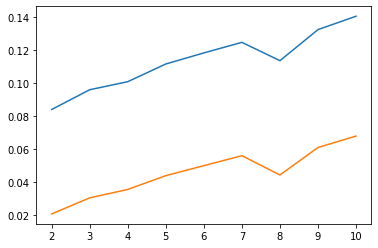

In [5]:
plt.plot(num_halos,mean_n2)

In [12]:
#this is the way to do it
num_ranks=np.array([2,4,6,8,10,12,14,16])
lst_2halo=[]
for j in range(10):
    lst=[]
    for i in range(len(num_ranks)):
        output=!srun -n {num_ranks[i]} ./stencil2d-mpi.x+orig --nx 64 --ny 64 --nz 32 --num_iter 500 --num_halo 2
        lst.append(ast.literal_eval(output[-2].replace("], \\","]" ))[5:])
    lst_2halo.append(lst)

In [28]:
np.asarray(lst_2halo)[:,0,0]

array([0.08346915, 0.083022  , 0.08262467, 0.08215475, 0.08502173,
       0.08257842, 0.08754325, 0.0831089 , 0.08486605, 0.08414125])

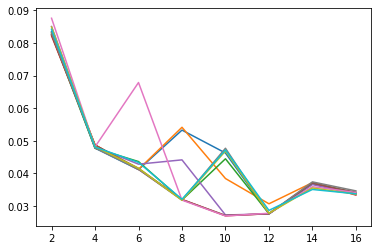

In [33]:
for i in range(10):
    plt.plot(num_ranks, np.asarray(lst_2halo)[i,:,0])

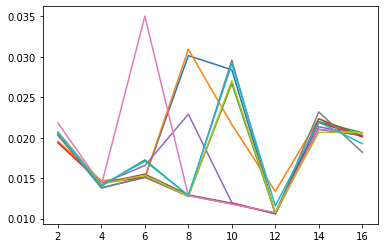

In [34]:
for i in range(10):
    plt.plot(num_ranks, np.asarray(lst_2halo)[i,:,1])

<ErrorbarContainer object of 3 artists>

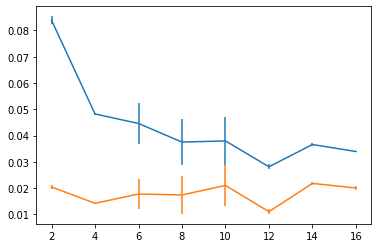

In [19]:
mean_halo2=np.mean(lst_2halo, axis=0)
std_halo2=np.std(lst_2halo, axis=0)
plt.errorbar(num_ranks,mean_halo2[:,0],yerr=std_halo2[:,0])
plt.errorbar(num_ranks,mean_halo2[:,1],yerr=std_halo2[:,1])

In [82]:
#this is the way to do it
num_ranks=np.array([2,4,6,8,10,12,14,16,18,20])
num_halos=np.arange(2,16)
df2 = pd.DataFrame(columns = num_ranks, index = num_halos)
for l in range(len(num_halos)):
    for i in range(len(num_ranks)):
        lst_both_const=[]
        for j in range(10):
            output=!srun -n {num_ranks[i]} ./stencil2d-mpi.x+orig --nx 64 --ny 64 --nz 32 --num_iter 500 --num_halo {num_halos[l]}
            lst_both_const.append(ast.literal_eval(output[-2].replace("], \\","]" ))[5:])
        mean_val=np.mean(lst_both_const, axis=0)
        std_val=np.std(lst_both_const, axis=0)
        df2.at[num_halos[l],num_ranks[i]] = [mean_val.tolist(), std_val.tolist()]
        
df2.to_csv('dataframes/big_df2.csv')

In [ ]:
#this is the way to do it more than 1 node
num_ranks=np.array([2,4,6,8,10,12,14,16,18,20,22,24])
num_halos=np.arange(2,16)
df2 = pd.DataFrame(columns = num_ranks, index = num_halos)
for l in range(len(num_halos)):
    for i in range(len(num_ranks)):
        lst_both_const=[]
        for j in range(10):
            output=!srun -n {num_ranks[i]} ./stencil2d-mpi.x+orig --nx 128 --ny 128 --nz 32 --num_iter 50 --num_halo {num_halos[l]}
            lst_both_const.append(ast.literal_eval(output[-2].replace("], \\","]" ))[5:])
        mean_val=np.mean(lst_both_const, axis=0)
        std_val=np.std(lst_both_const, axis=0)
        df2.at[num_halos[l],num_ranks[i]] = [mean_val.tolist(), std_val.tolist()]
        
df2.to_csv('dataframes/big_df_128.csv')

In [ ]:
output

In [7]:
%%bash
echo "====== 64 x 64 x 32 ======"
srun -n 2 ./stencil2d-mpi.x --nx 512 --ny 512 --nz 32 --num_halo 2 --num_iter 500 > report_512x512x32_2.txt

====== 64 x 64 x 32 ======


CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


In [14]:
%%bash
pat_report -O calltree+src /users/class197/bin/myproject/stencil2d-mpi.x+10526-4871s

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02

Number of PEs (MPI ranks):   12
                           
Numbers of PEs per Node:      6  PEs on each of  2  Nodes
                           
Numbers of Threads per PE:    1
                           
Number of Cores per Socket:  12

Accelerator Model: Nvidia P100-PCIE-16GB Memory: 16.00 GB Frequency: 1.19 GHz

Accelerator Driver Version: 470.57.2

Execution start time:  Sat Sep 24 19:32:55 2022

System name and speed:  nid04871  3.000 GHz (nominal)

Intel Haswell              CPU  Family:  6  Model: 63  Stepping:  2

DRAM:  64 GiB DDR4-2400 on 2.6 GHz nodes


Current path to data file:
  /users/class197/bin/myproject/stencil2d-mpi.x+10526-4871s   (RTS, 12 data files)



Processing step 1 of 1



Notes for table 1:

  This table shows functions that have significant exclusive time,
    averaged across ranks, as the leaves in a calltree view. Time
    shown for a callsite (non-leaf) is the sum of times below it in
    the tree. Where possible, callsites within a calling function are
    identified by source file and line number.
  For further explanation, see the "General table notes" below,
    or use:  pat_report -v -O calltree+src ...

Table 1:  Calltree View with Callsite Line Numbers

  Samp% | Samp | Calltree
        |      |  PE=HIDE
       
 100.0% |  3.0 | Total
|----------------------------------------------------------------
| 100.0% |  3.0 | main_:stencil2d-mpi.F90:line.85
||---------------------------------------------------------------
||  30.6% |  0.9 | apply_diffusion$main_:stencil2d-mpi.F90:line.175
||  25.0% |  0.8 | apply_diffusion$main_:stencil2d-mpi.F90:line.170
|||--------------------------------------------------------------
3||  11.1% |  0.3 | update_hal

In [5]:
%%bash
pat_report /users/class197/bin/myproject/stencil2d-mpi.x+22636-4872s

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02

Number of PEs (MPI ranks):   12
                           
Numbers of PEs per Node:      6  PEs on each of  2  Nodes
                           
Numbers of Threads per PE:    1
                           
Number of Cores per Socket:  12

Accelerator Model: Nvidia P100-PCIE-16GB Memory: 16.00 GB Frequency: 1.19 GHz

Accelerator Driver Version: 470.57.2

Execution start time:  Sat Sep 24 20:10:02 2022

System name and speed:  nid04872  2.984 GHz (nominal)

Intel Haswell              CPU  Family:  6  Model: 63  Stepping:  2

DRAM:  64 GiB DDR4-2400 on 2.6 GHz nodes


Current path to data file:
  /users/class197/bin/myproject/stencil2d-mpi.x+22636-4872s   (RTS, 12 data files)



Processing step 1 of 15
Suggested trace options file:   /users/class197/bin/myproject/stencil2d-mpi.x+22636-4872s/build-options.apa




Notes for table 1:

  This table shows functions that have significant exclusive sample
    hits, averaged across ranks.
  For further explanation, see the "General table notes" below,
    or use:  pat_report -v -O samp_profile ...

Table 1:  Profile by Function

  Samp% |  Samp | Imb. |  Imb. | Group
        |       | Samp | Samp% |  Function
        |       |      |       |   PE=HIDE
       
 100.0% | 216.3 |   -- |    -- | Total
|-----------------------------------------------------
|  95.9% | 207.4 |   -- |    -- | USER
||----------------------------------------------------
||  91.5% | 197.9 |  8.1 |  4.3% | apply_diffusion$main_
||   4.4% |   9.5 |  3.5 | 29.4% | update_halo$main_
||====================================================
|   4.1% |   8.9 |   -- |    -- | MPI
||----------------------------------------------------
||   3.2% |   6.8 |  4.2 | 41.3% | MPI_WAITALL
|=====================================================

Notes for table 2:

  This table shows functions that

Processing step 15 of 15



Notes for table 7:

  This table shows total wall clock time for the ranks with the
    maximum, mean, and minimum time, as well as the average across
    ranks.
    It also shows maximum memory usage from /proc/self/numa_maps for
    those ranks, and on average.  The usage is total size of all
    pages, including huge pages, that were actually mapped into
    physical memory from both private and shared memory segments.
  For further explanation, see the "General table notes" below,
    or use:  pat_report -v -O program_time ...

Table 7:  Wall Clock Time, Memory High Water Mark

  Process |   Process | PE=[mmm]
     Time |     HiMem | 
          | (MiBytes) | 
         
 2.426668 |     112.0 | Total
|-------------------------------
| 2.558689 |     300.1 | pe.0
| 2.408207 |      92.8 | pe.9
| 2.407531 |      92.9 | pe.1
|===============================

========================  Additional details  ========================



General table notes:

    The default notes for a table 

In [157]:
num_ranks=np.array([2,4,8,12,16])
#num_ranks=np.array([2,4])
runtimes=[]
runtimes_mean=[]
runtimes_std=[]

for i in num_ranks:
    output = !srun -n {i} ./stencil2d-mpi.x+orig --nx 64 --ny 64 --nz 32 --num_iter 100 --num_halo 2
    df = np.asarray(output)
    df = [ast.literal_eval(i) for i in df.tolist()]
    df=np.asarray(df)
    runtimes.append(df[:,5].tolist())

for j in range(len(num_ranks)):
    runtimes_mean.append(np.mean(runtimes[j]))
    runtimes_std.append(np.std(runtimes[j]))



In [19]:
df_plot = pd.read_csv ('dataframes/big_df.csv')
for i in np.arange(0,14):
    for j in np.array([4,9,12,16,20]):
        df_plot.at[i,str(j)]=ast.literal_eval(df_plot.at[i,str(j)])

In [3]:
#run this cell to plot data from dataframe
num_ranks=np.array([2,4,6,8,10,12,14,16,18,20])
num_halos=np.arange(2,16)

df2_plot = pd.read_csv ('dataframes/big_df3.csv')
for i in num_halos:
    for j in num_ranks:
        df2_plot.at[i-2,str(j)]=ast.literal_eval(df2_plot.at[i-2,str(j)])

z_tot=[]    
for i in num_ranks: 
    y=[]
    for j in num_halos:
        z_tot.append(df2_plot.loc[j-2][str(i)][0][1])
    #z_tot.append(y)
    #plt.plot(num_ranks, y)

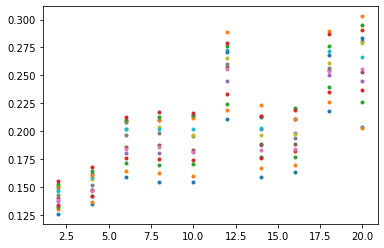

In [7]:
for j in num_halos:  
    y=[]
    for i in num_ranks:
        y.append((df2_plot.loc[j-2][str(i)][0][0]-df2_plot.loc[j-2][str(i)][0][1])*i)

    plt.plot(num_ranks, y,'.')

In [27]:
#model assuming that we are memory bound
def runtime(p, num_halo, alpha, beta_between_ranks):
    num_iter=500
    nx=64
    ny=64
    nz=32
    nx=nx/np.sqrt(p)
    ny=ny/np.sqrt(p)
    #alpha=1/500
    #beta_between_ranks=1/100
    beta_within_ranks=[1/68.3,1/77.5,1/155,1/155]
    cachesize=[32e3,256e3,30e6]
    lat_cache=np.array([4,15,51,151])/3e9
    T_comm=4*alpha + 4*(2*nx*num_halo+2*(ny+2*num_halo)*num_halo)*nz*beta_between_ranks
    for i in range(len(cachesize)):
        if 4*nx*ny*nz/p<cachesize[i]:
            T_per_rank=lat_cache[i]*nx*ny*nz/p #+ beta_within_ranks[i]*nx*ny*nz/p
        
        elif i==2:
            T_per_rank=lat_cache[3]*nx*ny*nz/p #+ beta_within_ranks[i]*nx*ny*nz/p
    T=num_iter*(T_comm+T_per_rank)
    
    return T_comm,T_per_rank, T


#alpha is overhead at sender/receiver + latency (2o + l)
def runtime_halo_update(X, alpha, beta_between_ranks):
    num_ranks,num_halo=X
    num_iter=500
    nx=64
    ny=64
    nz=32
    nx=nx/np.sqrt(num_ranks)
    ny=ny/np.sqrt(num_ranks)
    #alpha=1/500
    #beta_between_ranks=1/100
    #beta_within_ranks=[1/68.3,1/77.5,1/155,1/155]
    #cachesize=[32e3,256e3,30e6]
    #lat_cache=np.array([4,15,51,151])/3e9
    T_comm=[]
    for h,p in zip(range(len(num_ranks)),range(len(num_halo))):
        T_comm_p=num_iter*(4*alpha + 4*(2*nx[p]*num_halo[h]+2*(ny[p]+2*num_halo[h])*num_halo[h])*nz*beta_between_ranks)
        T_comm.append(T_comm_p.tolist())
    #T_comm=[item for sublist in T_comm for item in sublist]
    return T_comm

def runtime_halo_update_0(num_halo, alpha, beta_between_ranks, p):
    #p=6
    num_iter=500
    nx=64
    ny=64
    nz=32
    nx=nx/np.sqrt(p)
    ny=ny/np.sqrt(p)
    #alpha=1/500
    #beta_between_ranks=1/100
    #beta_within_ranks=[1/68.3,1/77.5,1/155,1/155]
    #cachesize=[32e3,256e3,30e6]
    #lat_cache=np.array([4,15,51,151])/3e9
    T_comm=4*alpha*np.log(p) + 4*(2*nx*num_halo+2*(ny+2*num_halo)*num_halo)*nz*beta_between_ranks
    T_comm=num_iter*T_comm
    return T_comm

In [123]:
y=[]
for j in num_halos:
    y.append(df2_plot.loc[j-2][str(6)][0][1])
coeff, cov =curve_fit(runtime_halo_update_0, np.arange(2,16), y)

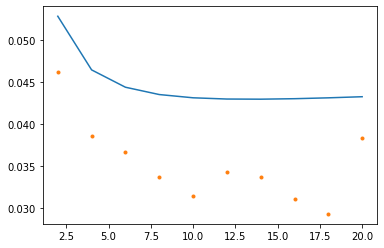

In [102]:
plt.plot(num_ranks,runtime_halo_update_0(8, coeff[0], coeff[1], num_ranks))


y=[]
for j in num_ranks:
    y.append(df2_plot.loc[8-2][str(j)][0][1])

plt.plot(num_ranks, y,'.')


In [22]:
z_tot

[0.024123788,
 0.016086811,
 0.021389726,
 0.016808887,
 0.016451388,
 0.01569897,
 0.016471208,
 0.016686469000000002,
 0.014178931999999997,
 0.0140029037,
 0.033761155,
 0.022284842000000003,
 0.025120067000000003,
 0.020444539,
 0.019542382,
 0.019017447,
 0.021805247,
 0.019646168,
 0.019829659,
 0.015618580000000002,
 0.038085378,
 0.026332723000000002,
 0.027369215000000002,
 0.022265568000000003,
 0.024605746,
 0.023934122,
 0.024585768,
 0.022290543,
 0.028488583,
 0.026305811000000002,
 0.045867228,
 0.033375663,
 0.032254715,
 0.02655881,
 0.028950917000000003,
 0.028113252,
 0.025972298000000005,
 0.027566113999999996,
 0.026151725999999997,
 0.030720151999999994,
 0.052645717999999994,
 0.040043569999999994,
 0.036784463,
 0.031572402,
 0.034359288,
 0.034737704,
 0.034905737,
 0.032134481000000006,
 0.034740937000000006,
 0.031902897,
 0.059203792,
 0.046539515,
 0.042372957999999995,
 0.035823034000000004,
 0.03663383300000001,
 0.036170256,
 0.038036049,
 0.034764984,
 

In [57]:
cov

array([[ 9.79242859e-14, -1.91416008e-18],
       [-1.91416008e-18,  5.30973409e-23]])

In [32]:
from scipy.optimize import curve_fit
num_ranks=np.array([2,4,6,8,10,12,14,16,18,20])
p=[]
num_r=num_ranks.tolist()
for i in range(len(num_r)):
    p.append(14*num_r[i:i+1])
p=[item for sublist in p for item in sublist]
y = np.array(10*num_halos.tolist())
p0= 1/500, 1/100
coeff, cov =curve_fit(runtime_halo_update, (p,y), np.array(z_tot))


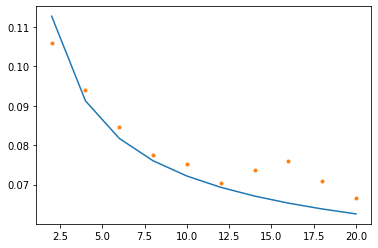

In [33]:

num_ranks=np.array([2,4,6,8,10,12,14,16,18,20])
#num_ranks=14*[10]
num_halo=10*[15]
#num_halo=np.arange(2,16)
X=(num_ranks, num_halo)
plt.plot(num_ranks,runtime_halo_update(X, coeff[0], coeff[1]))

y_plot=[]
for i in num_ranks:
    y_plot.append(df2_plot.loc[15-2][str(i)][0][1])

plt.plot(num_ranks,y_plot,'.')


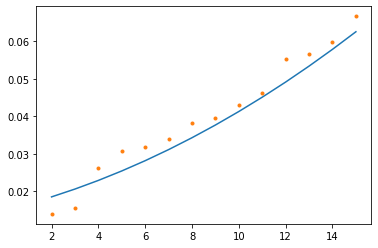

In [34]:

#num_ranks=np.array([2,4,6,8,10,12,14,16,18,20])
num_ranks=14*[20]
#num_halo=10*[12]
num_halo=np.arange(2,16)
X=(num_ranks, num_halo)
plt.plot(num_halos,runtime_halo_update(X, coeff[0], coeff[1]))

y_plot=[]
for i in num_halos:
    y_plot.append(df2_plot.loc[i-2][str(20)][0][1])

plt.plot(num_halos,y_plot,'.')

In [41]:
num_ranks=np.array([2,4,6,8,10,12,14,16,18,20])
p=[]
num_r=num_ranks.tolist()
for i in range(len(num_r)):
    p.append(14*num_r[i:i+1])
p=[item for sublist in p for item in sublist]
y = np.array(10*num_halos.tolist())
X=(p,y)
resid=np.array(z_tot)-np.array(runtime_halo_update(X, coeff[0], coeff[1]))
RSS=np.sum(resid**2)

(array([ 1.,  0.,  1.,  0.,  6.,  5., 21., 19., 24., 20., 21., 13.,  5.,
         3.,  1.]),
 array([-0.01482634, -0.01312479, -0.01142324, -0.00972169, -0.00802014,
        -0.00631859, -0.00461704, -0.00291549, -0.00121394,  0.00048762,
         0.00218917,  0.00389072,  0.00559227,  0.00729382,  0.00899537,
         0.01069692]),
 <BarContainer object of 15 artists>)

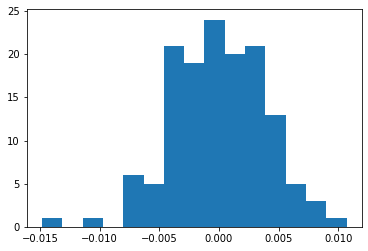

In [50]:
plt.hist(resid,bins=15)

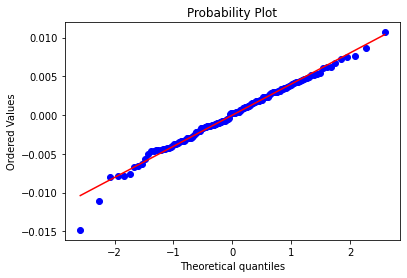

In [56]:
import scipy.stats as stats
import pylab
stats.probplot(resid, dist="norm",plot=pylab)
pylab.show()

In [58]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm



ModuleNotFoundError: No module named 'statsmodels'

In [155]:
num_ranks=np.array([2,4,8,12,16])
#num_ranks=np.array([2,4])
runtimes=[]
runtimes_mean=[]
runtimes_std=[]

for i in num_ranks:
    output = !srun -n {i} ./stencil2d-mpi.x+orig --nx 64 --ny 64 --nz 32 --num_iter 100 --num_halo 2
    runtimes.append(output)

In [156]:
runtimes

[['[    0,   64,   64,   32,     100,  0.1690745E-01]',
  '[    1,   64,   64,   32,     100,  0.1692390E-01]'],
 ['[    0,   64,   64,   32,     100,  0.9833574E-02]',
  '[    1,   64,   64,   32,     100,  0.9857178E-02]',
  '[    2,   64,   64,   32,     100,  0.9851456E-02]',
  '[    3,   64,   64,   32,     100,  0.9836912E-02]'],
 ["*** Error in `/users/class197/bin/myproject/./stencil2d-mpi.x+orig': free(): invalid pointer: 0x00000000006113d0 ***",
  "stencil2d-mpi.x+orig: malloc.c:4025: _int_malloc: Assertion `(unsigned long) (size) >= (unsigned long) (nb)' failed.",
  "*** Error in `/users/class197/bin/myproject/./stencil2d-mpi.x+orig': free(): invalid pointer: 0x000000000050ee50 ***",
  "*** Error in `/users/class197/bin/myproject/./stencil2d-mpi.x+orig': free(): invalid pointer: 0x00000000004cb790 ***",
  "*** Error in `/users/class197/bin/myproject/./stencil2d-mpi.x+orig': free(): invalid pointer: 0x00000000004cb790 ***",
  "*** Error in `/users/class197/bin/myproject/./ste

In [70]:
runtimes_mean12=np.mean(runtimes_mean_list12,axis=0)
runtimes_std12=np.std(runtimes_mean_list12,axis=0)

In [119]:
runtimes_std=np.std(runtimes_mean_list12, axis=0)
runtimes_std

array([5.66254167e-05, 1.78704167e-05, 2.89584208e-03, 6.65887500e-05,
       3.91808333e-05, 1.75337500e-05, 1.54972083e-04, 3.82190917e-03])

In [75]:
d = {'mean': runtimes_mean12.tolist(), 'std': runtimes_std12.tolist()}
df_12 = pd.DataFrame(data=d)
df_12.to_csv('dataframes/df_12.csv')

<ErrorbarContainer object of 3 artists>

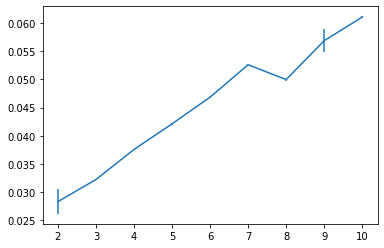

In [71]:
plt.errorbar(num_halos,runtimes_mean12, yerr=runtimes_std12)

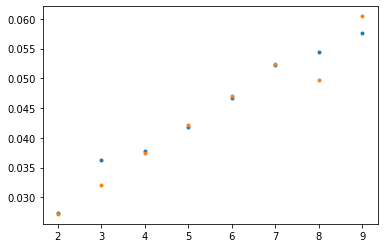

In [101]:
for j in range(2):
    plt.errorplot(num_halos,runtimes_mean[j],'.')

plt.plot(num_halos,runtimes_mean,'.')

In [64]:

def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

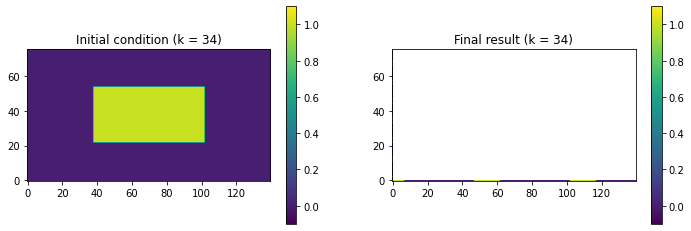

In [65]:
validate_results()

In [58]:
out_field = read_field_from_file('out_field.dat')
out_field

array([[[0.000000e+00, 0.000000e+00, 4.107039e-39, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00]],

       [[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        ...,


In [ ]:

!srun -n 12 ./stencil2d-mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_counter_128x128x64.txt

In [ ]:
!srun -n 12 ./stencil2d-mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_counter_128x128x64.txt

In [ ]:
num_ranks=np.array([2,4,6,8,9,10,12,14,16])
#num_ranks=np.array([2,4])
runtimes=[]
runtimes_mean=[]
runtimes_std=[]

for i in num_ranks:
    output = !srun -n {i} ./stencil2d-mpi.x+orig --nx 64 --ny 64 --nz 32 --num_iter 500 --num_halo 2
    df = np.asarray(output)
    df = [ast.literal_eval(i) for i in df.tolist()]
    df=np.asarray(df)
    runtimes.append(df[:,5].tolist())

for j in range(len(num_ranks)):
    runtimes_mean.append(np.mean(runtimes[j]))
    runtimes_std.append(np.std(runtimes[j]))

